# Affirmation Sample selection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.fitting.jax import Optimizer
# import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.jax.sersic import _b
import gzbuilder_analysis.fitting as fitting
from asinh_cmap import asinh_cmap

In [3]:
fm = pd.read_pickle('lib/fitting_metadata.pkl')

In [4]:
agg_res_path = 'output_files/aggregation_results'
agg_results = pd.Series([])
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(join(agg_res_path, f))

100%|██████████| 296/296 [00:03<00:00, 86.52it/s]


In [5]:
def show_contours(model, idx, percentile=95, ax=None):
    if ax is not None:
        plt.sca(ax)
    shape = fm.loc[idx]['galaxy_data'].shape
    psf = fm.loc[idx]['psf']
    for i, c in enumerate(model.keys()):
        if model[c] is None or model[c] == []:
            continue
        m = deepcopy(model)
        m = {k: (
            v
            if k == c or (c =='spiral' and k == 'disk')
            else (None if k != 'spiral' else [])
        )  for k, v in m.items()}
        if not all(v == None or v == [] for v in m.values()):
            if c == 'spiral' and m['disk'] is not None:
                m['disk']['I'] = 0
            r = rendering.calculate_model(m, image_size=shape, psf=psf)
            cs = plt.contour(
                r, levels=[np.percentile(r.ravel(), percentile)], colors=[f'C{i}'],
            )
    
def make_plot(model, idx, **kwargs):
    shape = fm.loc[idx]['galaxy_data'].shape
    render = rendering.calculate_model(
        model, image_size=shape, psf=fm.loc[idx]['psf']
    )
    _, ax = plt.subplots(ncols=3, figsize=(12, 8), dpi=100)
    ax[0].set_title('Reference galaxy')
    ax[0].imshow(fm.loc[idx]['galaxy_data'], cmap=asinh_cmap)
    ax[1].set_title('Fake (Noisy)')
    ax[1].imshow(render + np.random.randn(*shape) * fm.loc[idx]['sigma_image'], cmap=asinh_cmap)
    ax[2].set_title('Fake (Contoured)')
    ax[2].imshow(
        render,
        cmap=asinh_cmap,
    )
    show_contours(model, idx, ax=ax[2], **kwargs)
    for a in ax:
        plt.sca(a)
        plt.axis('off')


## Single Exponential Disk model

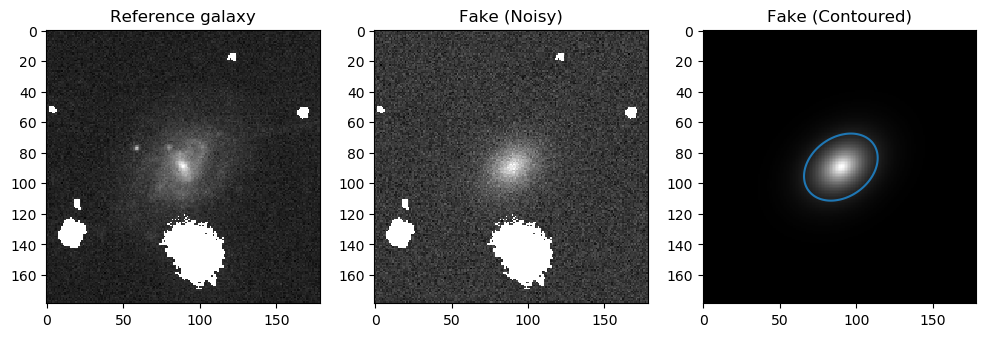

In [21]:
idx = 21686502
agr = agg_results.loc[idx]
agr.params
o = Optimizer(agr, fm.loc[idx])
target = fm.loc[idx].galaxy_data
render = np.asarray(o.render(o.p0))
_, ax = plt.subplots(ncols=3, figsize=(12, 8), dpi=100)
ax[0].set_title('Reference galaxy')
ax[0].imshow(target, cmap=asinh_cmap)
ax[1].set_title('Fake (Noisy)')
ax[1].imshow(render + np.random.randn(*render.shape) * fm.loc[idx]['sigma_image'], cmap=asinh_cmap)
ax[2].set_title('Fake (Contoured)')
ax[2].imshow(
    render,
    cmap=asinh_cmap,
)
show_contours(agr.model, idx, ax=ax[2])

In [ ]:
disk_only = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is None
        and m['bar'] is None
        and len(m['spiral']) == 0
    )    
)
print(disk_only[disk_only].index)
disk_idx = 21686502
disk_model = deepcopy(models['tuned_aggregate'].loc[disk_idx])
print(disk_idx)
make_plot(disk_model, disk_idx)
plt.savefig('affirmation_set_models/disk_model.png', bbox_inches='tight')
parsing.to_pandas(disk_model).unstack()

## Exponential Disk + Sersic Bulge model

In [ ]:
disk_bulge = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bulge']['n'] > 1
        and m['bar'] is None
        and len(m['spiral']) == 0
    )    
)
print(disk_bulge[disk_bulge].index)
disk_bulge_idx = 21096874
disk_bulge_model = deepcopy(models['tuned_aggregate'].loc[disk_bulge_idx])
print(disk_bulge_idx)
make_plot(disk_bulge_model, disk_bulge_idx)
plt.savefig('affirmation_set_models/disk_bulge_model.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_model).unstack()

## Exponential Disk + Sersic Bulge + Boxy Sersic Bar model

In [ ]:
disk_bulge_bar = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bar'] is not None
        and m['bulge']['Re'] > 0
        and m['bulge']['I'] > 0
        and m['bar']['Re'] > 0
#         and m['bar']['I'] > 0
    )    
)
print(disk_bulge_bar[disk_bulge_bar].index)
disk_bulge_bar_idx = 20902035
print(disk_bulge_bar_idx)
disk_bulge_bar_model = deepcopy(models['tuned_aggregate'].loc[disk_bulge_bar_idx])
disk_bulge_bar_model['bar']['q'] = 0.3
disk_bulge_bar_model['bar']['c'] = 4
disk_bulge_bar_model['spiral'] = []
make_plot(disk_bulge_bar_model, disk_bulge_bar_idx)
plt.savefig('affirmation_set_models/disk_bulge_bar_model.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_bar_model).unstack()

## Exponential Disk + Sersic Bulge + Boxy Sersic Bar + 2 Logarithmic spirals model

In [ ]:
disk_bulge_bar_2spiral_idx = 21686529
disk_bulge_bar_2spiral_model = deepcopy(models['tuned_aggregate'].loc[disk_bulge_bar_2spiral_idx])
print(disk_bulge_bar_2spiral_idx)
disk_bulge_bar_2spiral_model['bulge']['I'] = 0.12
disk_bulge_bar_2spiral_model['bulge']['q'] = 0.8
disk_bulge_bar_2spiral_model['bar']['q'] = 0.1
disk_bulge_bar_2spiral_model['bar']['I'] = 0.2
disk_bulge_bar_2spiral_model['bar']['n'] = 0.8
disk_bulge_bar_2spiral_model['bar']['c'] = 6
make_plot(disk_bulge_bar_2spiral_model, disk_bulge_bar_2spiral_idx)
plt.savefig('affirmation_set_models/disk_bulge_bar_2spiral_model.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_bar_2spiral_model).unstack()

In [ ]:
disk_bulge_bar_2spiral = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is not None
        and m['bar'] is not None
        and m['bulge']['Re'] > 0
        and m['bulge']['I'] > 0
        and m['bar']['Re'] > 0
        and m['bar']['I'] > 0
        and len(m['spiral']) >= 2
    )    
)
print(disk_bulge_bar_2spiral[disk_bulge_bar_2spiral].index)
disk_bulge_bar_2spiral_idx2 = a
disk_bulge_bar_2spiral_model2 = deepcopy(models['tuned_aggregate'].loc[disk_bulge_bar_2spiral_idx2])
print(disk_bulge_bar_2spiral_idx2)
disk_bulge_bar_2spiral_model2['bulge']['q'] = 0.8
disk_bulge_bar_2spiral_model2['bulge']['I'] = 0.1
make_plot(disk_bulge_bar_2spiral_model2, disk_bulge_bar_2spiral_idx2)
plt.savefig('affirmation_set_models/disk_bulge_bar_2spiral_model2.png', bbox_inches='tight')
parsing.to_pandas(disk_bulge_bar_2spiral_model2).unstack()

# Exponential Disk + 2 spirals model

In [ ]:
disk_2spiral = models['tuned_aggregate'][comb_mask].apply(
    lambda m: (
        m['disk'] is not None
        and m['bulge'] is None
        and m['bar'] is None
        and len(m['spiral']) >= 2
    )    
)
print(disk_2spiral[disk_2spiral].index)
disk_2spiral_idx = 21096996
disk_2spiral_model = deepcopy(models['tuned_aggregate'].loc[disk_2spiral_idx])
print(disk_2spiral_idx)
make_plot(disk_2spiral_model, disk_2spiral_idx)
plt.savefig('affirmation_set_models/disk_2spiral_model.png', bbox_inches='tight')
parsing.to_pandas(disk_2spiral_model).unstack()

In [ ]:
full_idx = 20901990
full_model = deepcopy(models['tuned_best_individual'].loc[full_idx])
full_model['bulge']['Re'] = 5
full_model['bulge']['I'] = 0.1
full_model['bulge']['n'] = 1
print(full_idx)
make_plot(full_model, full_idx, percentile=95)
plt.savefig('affirmation_set_models/full_model.png', bbox_inches='tight')
parsing.to_pandas(disk_2spiral_model).unstack()

In [ ]:
import lib.galaxy_utilities as gu

In [ ]:
{
    disk_idx: dict(model=disk_model, metadata=gu.metadata.loc[disk_idx].dropna()),
    disk_bulge_idx: dict(model=disk_bulge_model, metadata=gu.metadata.loc[disk_bulge_idx].dropna()),
    disk_bulge_bar_idx: dict(model=disk_bulge_bar_model, metadata=gu.metadata.loc[disk_bulge_bar_idx].dropna()),
    disk_bulge_bar_2spiral_idx: dict(model=disk_bulge_bar_2spiral_model, metadata=gu.metadata.loc[disk_bulge_bar_2spiral_idx].dropna()),
    disk_bulge_bar_2spiral_idx2: dict(model=disk_bulge_bar_2spiral_model2, metadata=gu.metadata.loc[disk_bulge_bar_2spiral_idx2].dropna()),
    full_idx: dict(model=full_model, metadata=gu.metadata.loc[full_idx].dropna()),
}

In [93]:
np.exp(-np.pi/2*np.tan(np.deg2rad(10)))

0.7580743784028148

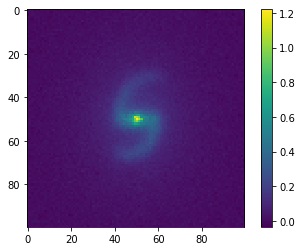

In [148]:
import jax.numpy as jnp
from gzbuilder_analysis.fitting import jax as fit

c, cs = fit._make_xy_arrays(np.zeros((100, 100)), 5)
model = dict(
    disk=dict(mux=50.0, muy=50.0, roll=0.0, Re=30, q=0.8, L=1000),
    bulge=dict(roll=0.0, scale=0.03, q=1.0, frac=0.1, n=1.8),
    bar=dict(roll=np.pi/2, scale=0.2, q=0.35, frac=0.06, n=0.7, c=3),
    centre=dict(mux=50.0, muy=50.0),
    spiral={
        't_min.0': np.pi*2/3,
        't_max.0': 0.0,
        'A.0': 10.0, 
        'I.0': 1.50,
        'spread.0': 1.0,
        'phi.0': 16.0,
        't_min.1': np.pi,
        't_max.1': np.pi + (np.pi*2/3),
        'A.1': 10*0.2,
        'I.1': 1.20,
        'spread.1': 1.0,
        'phi.1': 25.0,
    }
)
n_spirals = 2
distances = fit._get_distances(*c, model, n_spirals)
psf = jnp.asarray(fm.loc[20902040]['psf'])
r = fit.render(*cs, model, distances, psf, n_spirals)
plt.imshow(r + np.random.randn(*r.shape)*0.1*(0.1 + r**2))
plt.colorbar()

In [129]:
%timeit fit.render(*cs, model, distances, psf, n_spirals).block_until_ready();

55.2 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
